In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import xarray as xr
import datetime
import timeit


# Load example Data

## first loading `.csv` to `pandas`

In [6]:
data2D = pd.read_csv('WEA_beispiel.csv', sep=';', header=0, index_col=0).dropna()
data2D = data2D.reindex(sorted(data2D.columns), axis=1)
data2D.head()

,0.95,0.975,1,1.025,1.05,1.075,1.1,1.125,1.15,1.175,1.2,1.225,1.25,1.275
3.0,51,54,57,60,62,65,68,70,73,76,79,81,84,87
3.5,123,127,132,136,141,145,150,154,159,163,168,172,177,181
4.0,210,217,224,231,238,244,251,258,265,272,278,285,292,299
4.5,318,328,337,347,357,366,376,386,395,405,415,424,434,444
5.0,452,465,478,492,505,518,531,544,557,571,584,597,610,623


## Transforming the *Leistungskennlinie* to a *Windatlas* compatible format by building a `xarray` from `pandas` 

In [7]:
data_vars={'leistung':(['wspd','rho'], np.array(data2D), 
                        {'units': 'kWh',
                        'long_name':'Leistung aus Wind und Luftdichte'})}

coords = {
        "wspd": (["wspd"], np.array(data2D.index, dtype="float64")),
        "rho": (["rho"], np.array(data2D.columns, dtype="float64")),
        }

attrs = {'describtion':"interpolated Leistungskennlinie",
        'creation_date':datetime.date.today(), 
        'author':'Claudius Wehner'}

testarray2D = xr.DataArray(
    data=np.array(data2D),
    coords=coords,
    attrs=attrs
)
testarray2D

<xarray.DataArray (wspd: 44, rho: 14)>
array([[  51,   54,   57,   60,   62,   65,   68,   70,   73,   76,   79,
          81,   84,   87],
       [ 123,  127,  132,  136,  141,  145,  150,  154,  159,  163,  168,
         172,  177,  181],
       [ 210,  217,  224,  231,  238,  244,  251,  258,  265,  272,  278,
         285,  292,  299],
       [ 318,  328,  337,  347,  357,  366,  376,  386,  395,  405,  415,
         424,  434,  444],
       [ 452,  465,  478,  492,  505,  518,  531,  544,  557,  571,  584,
         597,  610,  623],
       [ 616,  633,  651,  669,  686,  704,  721,  739,  757,  774,  792,
         809,  827,  844],
       [ 813,  835,  858,  881,  904,  926,  949,  972,  995, 1017, 1040,
        1062, 1085, 1108],
       [1045, 1074, 1103, 1131, 1160, 1189, 1218, 1247, 1275, 1304, 1332,
        1361, 1389, 1418],
       [1317, 1353, 1389, 1425, 1461, 1496, 1532, 1568, 1603, 1639, 1674,
        1709, 1744, 1779],
       [1628, 1671, 1715, 1758, 1802, 1845, 1888, 1931, 1974, 2016, 2058,
        2101, 2143, 2185],
...
       [4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200, 4200,
        4200, 4200, 4200],
       [4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186, 4186,
        4186, 4186, 4186],
       [3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870, 3870,
        3870, 3870, 3870],
       [3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373, 3373,
        3373, 3373, 3373],
       [2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745, 2745,
        2745, 2745, 2744],
       [2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154, 2154,
        2154, 2154, 2154],
       [1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805, 1805,
        1805, 1805, 1805],
       [1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526, 1526,
        1526, 1526, 1526],
       [1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283, 1283,
        1283, 1283, 1283],
       [1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116, 1116,
        1116, 1116, 1116]])
Coordinates:
  * wspd     (wspd) float64 3.0 3.5 4.0 4.5 5.0 5.5 ... 22.5 23.0 23.5 24.0 24.5
  * rho      (rho) float64 0.95 0.975 1.0 1.025 1.05 ... 1.2 1.225 1.25 1.275
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-01-20
    author:         Claudius Wehner

# Interpolation

Interpolation is done using the scipy.interpolation package for both 1D and 2D interpolation of wind turbine power delivery data.
Examples for the here used methods can be found online:
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#d-spline-representation-object-oriented-bivariatespline

Text(0.5, 1.0, 'Interpolated data')

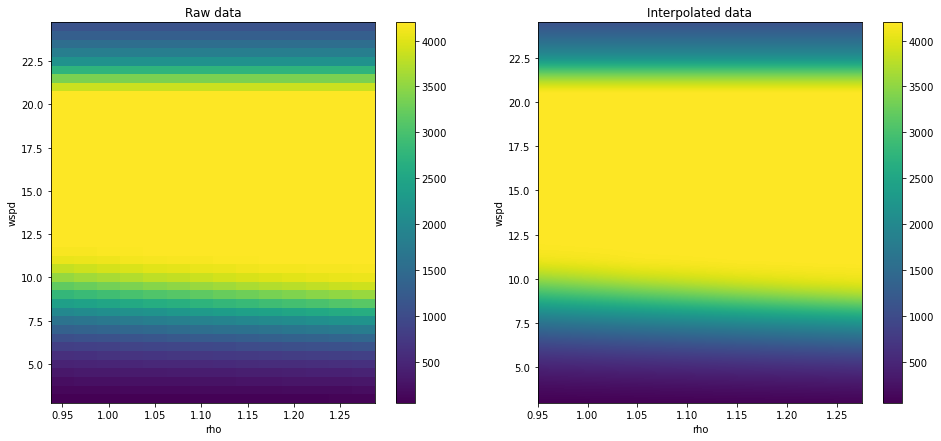

In [10]:
import matplotlib.pyplot as plt

increment_wspd = 0.001
increment_rho = 0.0001
power_limiter = True

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
testarray2D.plot(ax=axes[0])
axes[0].set_title("Raw data")

new_wspd = np.arange(testarray2D.wspd[0], testarray2D.wspd[-1]+increment_wspd, increment_wspd, dtype=np.float64)
new_rho = np.arange(testarray2D.rho[0], testarray2D.rho[-1]+increment_rho, increment_rho, dtype=np.float64)
testarray2Di = testarray2D.interp(wspd=new_wspd, rho=new_rho, method="cubic")

#### GOLDEN STEP TO MAKE .sel() WORK AFTER INTERPOLATION ####
# Reassigning helps solving the rounding error
testarray2Di = testarray2Di.assign_coords(
            coords={
                "wspd": testarray2Di.wspd.round(decimals=3),
                "rho": testarray2Di.rho.round(decimals=4)}
        )
#############################################################
if power_limiter:
    maxOriginalPower = testarray2D.max()
    testarray2Di = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)


testarray2Di.plot(ax=axes[1])
axes[1].set_title("Interpolated data")

Text(0.5, 1.0, 'Cut interpolated data')

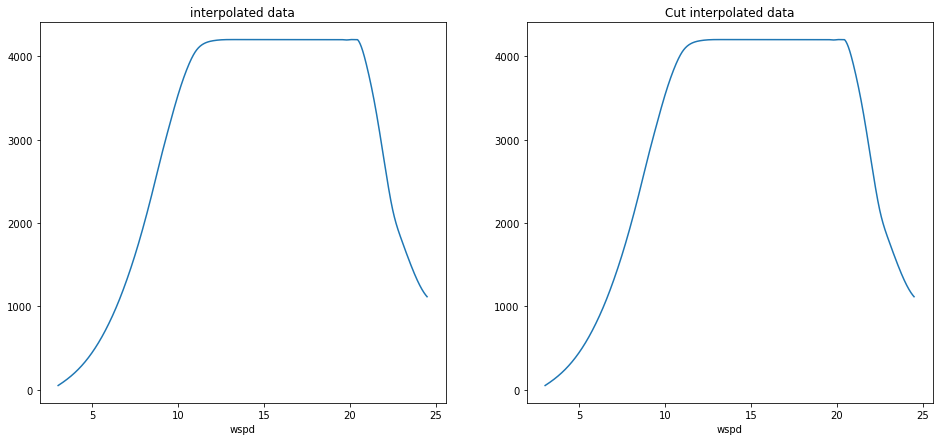

In [11]:
maxOriginalPower = testarray2D.max()

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
testarray2Di.isel(rho=7).plot(ax=axes[0])
axes[0].set_title("interpolated data")

test = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)

test.isel(rho=7).plot(ax=axes[1])
axes[1].set_title("Cut interpolated data")

In [13]:
size = 600000

wspd = np.around(np.random.uniform(float(data2D.wspd.min()), float(data2D.wspd.max()), size=size),1)#.astype(np.float64)
rho = np.around(np.random.uniform(float(data2D.rho.min()), float(data2D.rho.max()), size=size),3)#.astype(np.float64)
start = timeit.default_timer()
#### GOLDEN STEP ####
dummy = testarray2Di.sel(
    wspd=xr.DataArray(wspd, dims='z'), 
    rho=xr.DataArray(rho, dims='z'), 
    method=None)# if error appears, use method="nearest"
#####################
end = timeit.default_timer()
timed = end - start
del(wspd)
del(rho)
print(f'Time to get {size} "leistungs"-values from equivalent wspd and rho time series data: {timed}')
dummy#[:100]

Time to get 600000 "leistungs"-values from equivalent wspd and rho time series data: 0.050342743983492255


<xarray.DataArray (z: 600000)>
array([4195.22010327, 1691.09722454,  788.24496168, ..., 1991.02138855,
       1924.03707316, 1329.45170347])
Coordinates:
    wspd     (z) float64 19.8 23.2 5.7 23.6 3.9 19.7 ... 16.5 4.7 22.7 22.8 6.4
    rho      (z) float64 1.124 1.055 1.075 1.16 ... 1.202 1.134 1.234 1.255
Dimensions without coordinates: z
Attributes:
    describtion:    interpolated Leistungskennlinie
    creation_date:  2022-01-20
    author:         Claudius Wehner

<AxesSubplot:xlabel='z'>

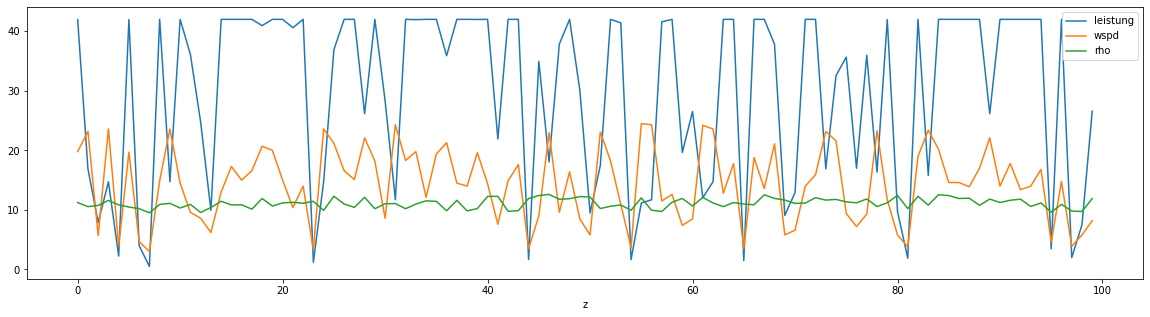

In [14]:
df = dummy.to_pandas().to_frame()
df = df.rename({0: "leistung"}, axis=1)
df["wspd"] = dummy.wspd.values
df["rho"] = dummy.rho.values *10
df.loc[:,"leistung"] = df["leistung"] /100
df.head(n=100).plot(figsize=(20,5))